# Water mass transformation analysis development notebook

This notebook is the analysis and visualization component of the `wmtf_dev.py` script

***

In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
from dateutil.parser import parse
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

### Plotting Functions

In [56]:
def extract_variable(ds, varname, timerange, region, seasons=None, tavg=True):
    """Extract a variable from an `xarray.Dataset` given constraints
    """
    
    # Define plotting seasons
    if seasons is None:
        seasons = ['DJF', 'MAM', 'JJA', 'SON']

    # Select values by season
    tslc = slice(*timerange)
    ds_slc = ds.sel(Time=tslc)
    tindex = [season in seasons for season in ds_slc.Time.dt.season]
    variable = ds_slc[varname].sel(Time=tindex, Regions=region)
    
    # Return time mean
    if tavg:
        variable = variable.mean(dim='Time')

    return variable


def plot_summary_sigma(ds, region, timeranges, seasons=None, xlim=[22, 27.8]):
    """Compare integrated WMT variables between MPAS-Ocean meshes
    as a function of sigma
    """
    
    # Make plot area
    fig, axs = plt.subplots(3, 2, figsize=(12, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.2})
    palette = plt.get_cmap('tab10')

    # Plot categories
    ctgys, titles, ylims = ['tr', 'fm'], ['Transformation', 'Formation'], [(-15, 20), (-5, 8)]
    for col, ctgy, title, ylim in zip(axs.T, ctgys, titles, ylims):

        col[0].set_title(title)
        col[1].set_ylabel('Sv')
        col[2].set_xlabel('$\\sigma_{\\theta}$')

        # Plot components
        for ax, name in zip(col, ['total', 'heat', 'fresh']):

            # Plot curves
            meshes = list(ds)
            for mesh, n in zip(meshes, range(2)):
                
                # Plot region 10-year averages
                for timerange, ls in zip(timeranges, [':', '-']):
                        
                    # Define plotting labels for legend
                    label = mesh if (ctgy == 'tr') and (ls == '-') else None
                    if (ctgy == 'fm') and (mesh == meshes[0]):
                        ax.plot(0, 0, 'k', ls=ls, label='-'.join(str(t.year) for t in timerange))

                    # Select variable and plot
                    variable = extract_variable(ds[mesh], f'{name}_{ctgy}', timerange, region)
                    ax.plot(variable.Sigmabins, variable, ls=ls, color=palette(n), label=label, zorder=1)

            # Plot and formatting
            ax.plot(xlim, [0, 0], 'k--')
            ax.plot([27.2, 27.2], ylim, '--', color='lightgray')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            # Row-specific formatting
            if name != 'fresh':
                ax.xaxis.set_ticklabels('')
            if ctgy == 'tr':
                ax.text(0.01, 0.92, name, transform=ax.transAxes)

    # More formatting
    axs[2, 0].legend(loc=4)
    axs[2, 1].legend(loc=4)
    
    return fig, axs


def plot_variable_sigma(ds, varname, regions, timeranges, seasons=None, xlim=[25, 28.2], ylim=[-10, 20]):
    """Compare integrated WMT variables between MPAS-Ocean meshes
    as a function of sigma
    """

    # Make plot area
    fig, axs = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    palette = plt.get_cmap('tab10')
    
    # Plot meshes
    meshes = list(ds)
    for ax, mesh in zip(axs, meshes):

        # Plot region 10-year averages
        for timerange, ls in zip(timeranges, [':', '-']):
            for n, region in enumerate(regions):
                
                # Define plotting labels for legend
                label = region if (mesh == meshes[0]) and (ls == '-') else None
                if (mesh == meshes[1]) and (region == regions[0]):
                    ax.plot(0, 0, 'k', ls=ls, label='-'.join(str(t.year) for t in timerange))
                
                # Select variable and plot
                variable = extract_variable(ds[mesh], varname, timerange, region, seasons=seasons)
                ax.plot(variable.Sigmabins, variable, ls=ls, color=palette(n), label=label, zorder=1)
        
        # Formatting
        ax.plot(xlim, [0, 0], 'k--', zorder=0)
        ax.plot([27.2, 27.2], ylim, '--', color='lightgray')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel('$\\sigma_{\\theta}$')
        ax.set_title(mesh)

    # More formatting
    axs[0].set_ylabel('Sv')
    axs[1].yaxis.set_ticklabels('')
    axs[0].legend(loc=2)
    axs[1].legend(loc=2)
    
    return fig, axs


def plot_variable_hoffmueller(ds, varname, region, timeranges, xlim=[25, 27.6]):
    """Compare integrated WMT variables between MPAS-Ocean meshes
    as a Hoffmueller plot
    """
    
    # Make plot area
    fig, axs = plt.subplots(2, 3, figsize=(12, 12), gridspec_kw={'hspace': 0.03, 'wspace': 0.1})

    # Plot timeranges
    meshes = list(ds)
    titles = meshes + [' - '.join(meshes)]
    for row, timerange in zip(axs, timeranges[::-1]):

        # Plot meshes
        residual = []
        for ax, mesh in zip(row, meshes):
            variable = extract_variable(ds[mesh], varname, timerange, region, tavg=False)
            sigma, time = [variable[name] for name in ('Sigmabins', 'Time')]
            c1 = ax.pcolormesh(sigma, time, variable, cmap='BrBG', vmin=-80, vmax=80)
            residual.append(variable)

        # Plot difference
        residual = np.subtract(*residual)
        c2 = row[2].pcolormesh(sigma, time, residual, cmap='RdBu_r', vmin=-80, vmax=80)
        ylim = time[[0, -1]]

        # Formatting
        for ax, title in zip(row, titles):
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.plot([27.2, 27.2], ylim, '--', color='lightgray')
            if title != meshes[0]:
                ax.yaxis.set_ticklabels('')
            if timerange[0].year == 1997:
                ax.set_title(title)
                ax.xaxis.set_ticklabels('')

    # Format axes    
    axs[1, 0].set_ylabel('Simulation date (monthly averages)', y=1)
    axs[1, 1].set_xlabel('$\\sigma_{\\theta}$')

    # Add colorbars
    caxs = [fig.add_axes([x, 0.055, dx, 0.01]) for x, dx in zip([0.13, 0.66], [0.49, 0.24])]
    for c, cax, labels in zip([c1, c2], caxs, [('Destruction', 'Formation'), meshes[::-1]]):
        fig.colorbar(c, cax=cax, label='Sv', orientation='horizontal')
        for x, label in zip([0.1, 0.9], labels):
            cax.text(x, 1.5, f'({label})', transform=cax.transAxes, ha='center')
    
    return fig, axs

***

### Load WMTR results

Definitions

In [4]:
# Results path
resultspath = '/pscratch/sd/b/bmoorema/results/wmtr/'

# Time ranges of interest
timeranges = [
    [parse(t) for t in ('1947 Jan 1', '1956 Dec 31')],
    [parse(t) for t in ('1997 Jan 1', '2006 Dec 31')],
]

Load `wmtr` results and calculate formation

In [5]:
# Load results
ds = {}
for mesh, yeartag in zip(['60to30E2r2', '18to6v3'], [2009, 2006]):
    
    # Load file
    filename = f'20210421_sim7_CORE_{mesh}.wmtr_19470101_{yeartag}1201.nc'
    ds[mesh] = xr.open_dataset(resultspath + filename)
    
    # Calculate total tr as new Dataset field
    total = sum([ds[mesh][name + '_tr'] for name in ('heat', 'fresh')])
    ds[mesh] = ds[mesh].assign(total_tr=total)
    
    # Calculate fm (-dF/drho) as new Dataset fields
    calc_fm = lambda x: -x.diff(dim='Sigmabins', label='lower')
    names = [name for name in list(ds[mesh]) if 'tr' in name]
    fm = {name.replace('tr', 'fm'): calc_fm(ds[mesh][name]) for name in names}
    ds[mesh] = ds[mesh].assign(fm)

***

### Results Overview (North Atlantic subbasin)

   1. TR curves in the MPAS runs are smaller than the curves for POP by about 5 Sv
   2. The heat flux contribution dominates the TR curves everywhere
   3. STMW and SPMW are both present in FR curces at low-res
   3. SPMW is more pronounced in the high-res but STMW formation nearly vanishes

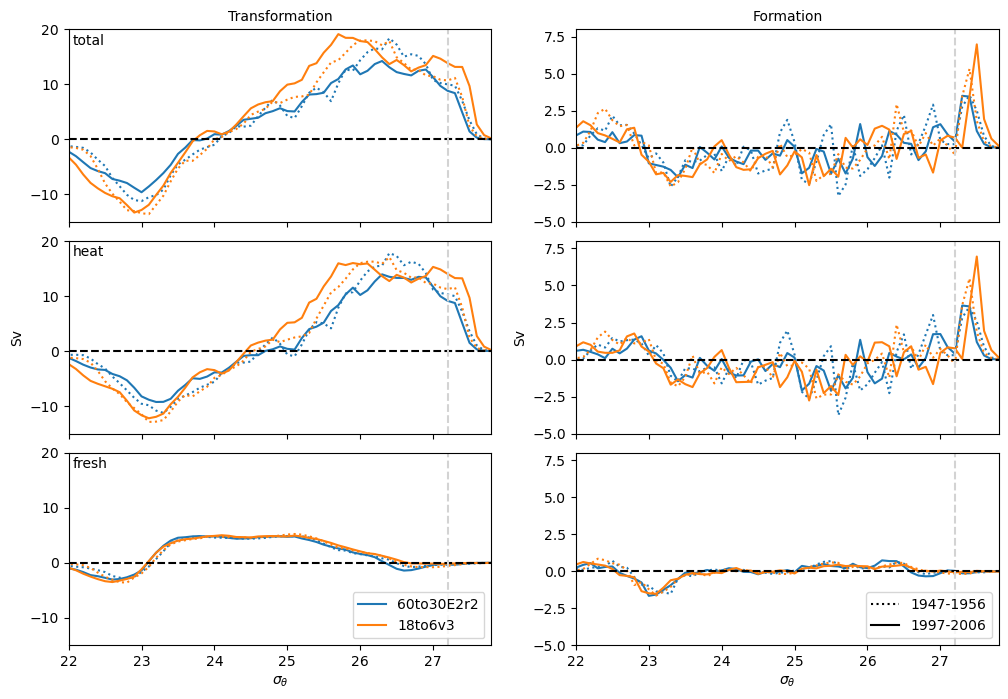

In [6]:
# Plot summary
fig, axs = plot_summary_sigma(ds, 'North Atlantic Ocean', timeranges)

***

### Total Formation: regional breakdown

Five subregions dominate STMW and SPMW formation in the forced low-res and high-res runs.

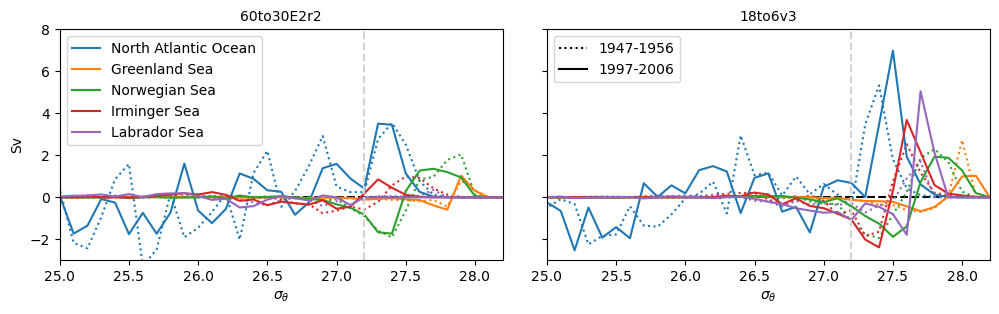

In [7]:
# NA mode water regions
regions = [
    'North Atlantic Ocean',
    'Greenland Sea',
    'Norwegian Sea',
    'Irminger Sea',
    'Labrador Sea',
]

# Plot regional breakdown
fig, axs = plot_variable_sigma(ds, 'total_fm', regions, timeranges, ylim=[-3, 8])

***

### Formation time variability (North Atlantic subbasin)

   1. Formation is concentrated in the winter
   2. Formation at 26.5 to 27.2 is persistently higher in low-res

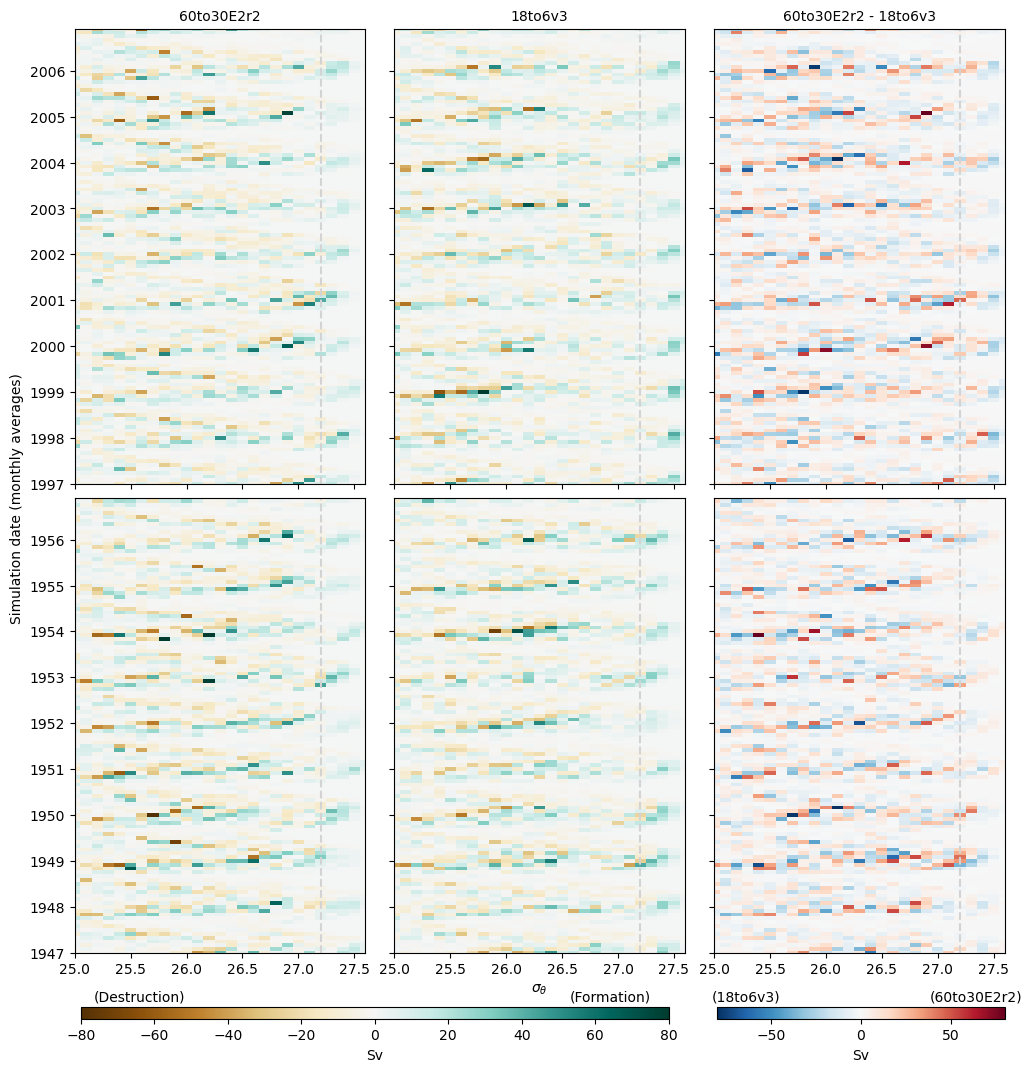

In [57]:
fig, axs = plot_variable_hoffmueller(ds, 'total_fm', 'North Atlantic Ocean', timeranges)

***

### Formation (winter only)

   1. Formation rates increase by a factor of about three
   2. STMW formation becomes more prevalent in both low-res and high-res

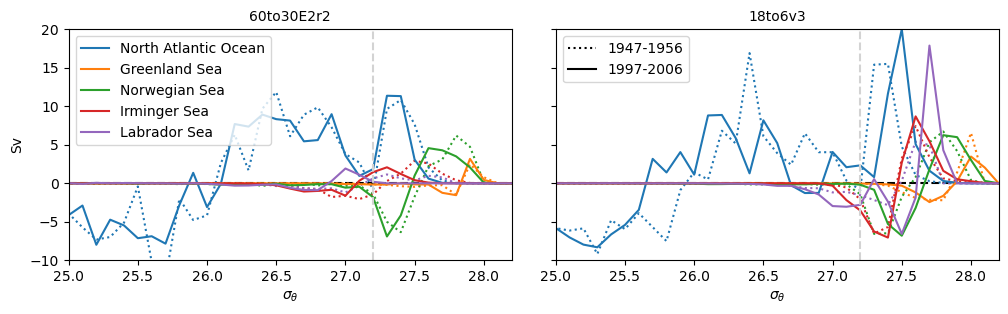

In [9]:
# NA mode water regions
regions = [
    'North Atlantic Ocean',
    'Greenland Sea',
    'Norwegian Sea',
    'Irminger Sea',
    'Labrador Sea',
]

# Plot regional breakdown
fig, axs = plot_variable_sigma(ds, 'total_fm', regions, timeranges, seasons=['DJF'], ylim=[-10, 20])